# $\mathrm{HCHO}$ (Formaldehyde)

In [69]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [70]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [71]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [72]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH2O" 
rxns = relevant_rxns(h5_path, species)

3-element Vector{Any}:
 "CH2O  to  (total)"
 "CH2O  to  H and HCO"
 "CH2O  to  H2 and CO"

In [73]:
rxn1 = rxns[end-1]
rxn2 = rxns[end]

"CH2O  to  H2 and CO"

There are two pathways for the decomposition that correspond to photolysis rates $J_{11}$ and $J_{12}$ in the MCM, respectively. We will therefore do a fit for both

In [74]:
rxn = rxn1
λs, Φs, T1s, T2s, species, source_idx, T_units, category, reaction, λ_units, Φ_units  = get_raw_data(h5_path, rxn)

([290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 290.0, 300.0  …  310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 345.0, 348.5, 355.0], [0.81, 0.66, 0.52, 0.4, 0.29, 0.18, 0.09, 0.01, 0.81, 0.66  …  0.52, 0.46, 0.4, 0.34, 0.29, 0.24, 0.08, 0.13, 0.09, 0.01], [298.0, 294.0, 294.0, 298.0, 296.0, 296.0, 298.0, 353.0, 220.0, 298.0, 298.0, 294.0, 300.0, 298.0, 373.0, 296.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  17, 17, 17, 17, 17, 17, 17, 17, 17, 17], "K", "Organics (carbonyls)", "CH2O → H+HCO", "nm", "")

In [75]:
unique(species)

2-element Vector{Int64}:
 1
 2

In [76]:
reaction

"CH2O → H+HCO"

In [77]:
species_to_use = 1 
df = data_to_df(λs, Φs, T1s, T2s, source_idx, species, species_to_use)

236×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   290.0     0.81    298.0          1
   2 │   300.0     0.66    298.0          1
   3 │   310.0     0.52    298.0          1
   4 │   320.0     0.4     298.0          1
   5 │   330.0     0.29    298.0          1
   6 │   340.0     0.18    298.0          1
   7 │   350.0     0.09    298.0          1
   8 │   360.0     0.01    298.0          1
   9 │   299.1     0.7     294.0          2
  10 │   317.2     0.7     294.0          2
  11 │   326.2     0.42    294.0          2
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 227 │   310.0     0.52    298.0         17
 228 │   315.0     0.46    298.0         17
 229 │   320.0     0.4     298.0         17
 230 │   325.0     0.34    298.0         17
 231 │   330.0     0.29    298.0         17
 232 │   335.0     0.24    298.0         17
 233 │   340.0     0.08    298.0         17
 234 │   345.0     0.13    298.0         17
 235 │   348.5     0.09    298.0         17
 236 │   355.0     0.01    298.0         17
                            215 rows omitted

In [78]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [79]:
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

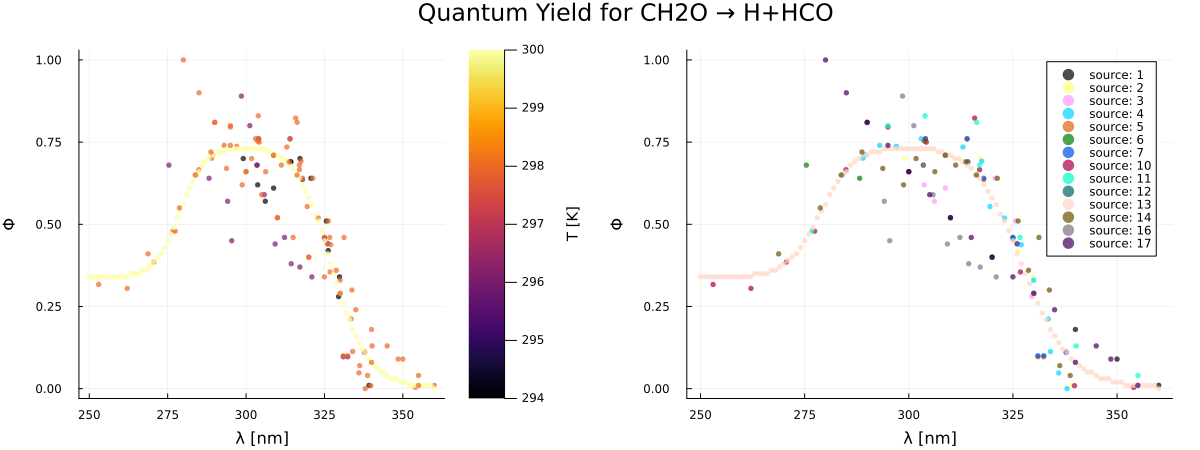

In [80]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    df.Φ[1:nskip:end],
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        df_g.Φ[1:nskip:end],
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="Φ",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Quantum Yield for $(reaction)",)

In [81]:
df = df[df.source_id .== 13, :]

111×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   250.0     0.34    300.0         13
   2 │   251.0     0.34    300.0         13
   3 │   252.0     0.34    300.0         13
   4 │   253.0     0.34    300.0         13
   5 │   254.0     0.34    300.0         13
   6 │   255.0     0.34    300.0         13
   7 │   256.0     0.34    300.0         13
   8 │   257.0     0.34    300.0         13
   9 │   258.0     0.34    300.0         13
  10 │   259.0     0.34    300.0         13
  11 │   260.0     0.34    300.0         13
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 102 │   351.0     0.02    300.0         13
 103 │   352.0     0.01    300.0         13
 104 │   353.0     0.01    300.0         13
 105 │   354.0     0.01    300.0         13
 106 │   355.0     0.01    300.0         13
 107 │   356.0     0.01    300.0         13
 108 │   357.0     0.01    300.0         13
 109 │   358.0     0.01    300.0         13
 110 │   359.0     0.01    300.0         13
 111 │   360.0     0.0     300.0         13
                             90 rows omitted

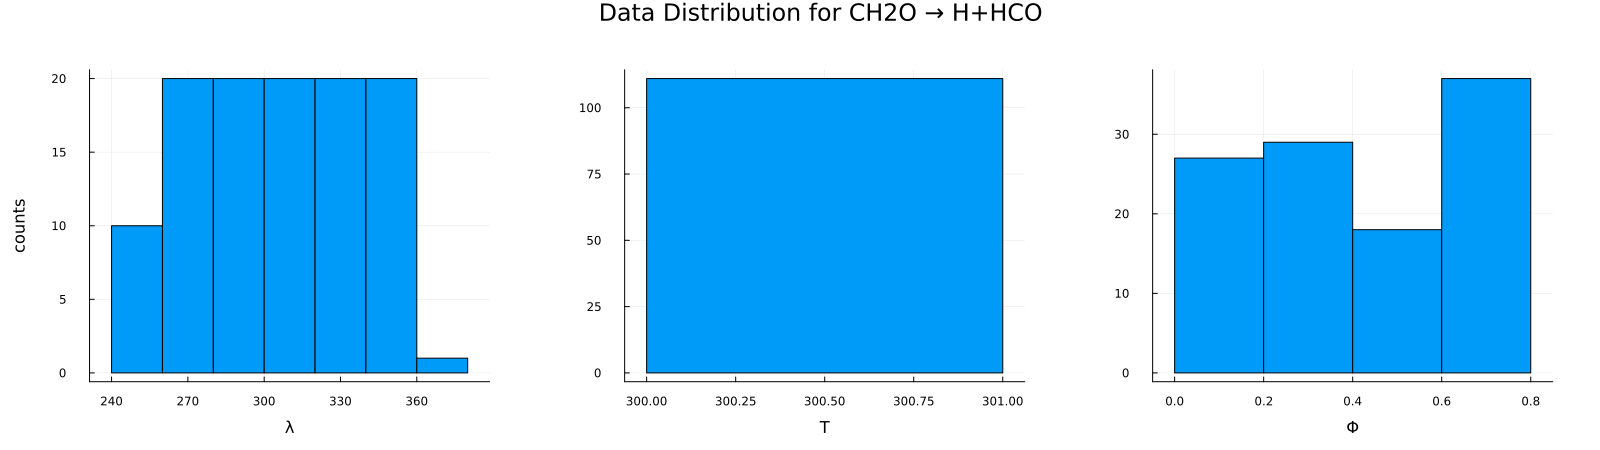

In [82]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df.Φ, xlabel="Φ", label="", margin=10Plots.mm)
phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(reaction)")

# Data Preprocessing

In [83]:
gdfs = groupby(df, :T)

res_dfs = [] 

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:Φ, :T] .=> mean, renamecols=false))
end

df_unique = vcat(res_dfs...)

111×3 DataFrame
 Row │ λ        Φ        T       
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │   250.0     0.34    300.0
   2 │   251.0     0.34    300.0
   3 │   252.0     0.34    300.0
   4 │   253.0     0.34    300.0
   5 │   254.0     0.34    300.0
   6 │   255.0     0.34    300.0
   7 │   256.0     0.34    300.0
   8 │   257.0     0.34    300.0
   9 │   258.0     0.34    300.0
  10 │   259.0     0.34    300.0
  11 │   260.0     0.34    300.0
  ⋮  │    ⋮        ⋮        ⋮
 102 │   351.0     0.02    300.0
 103 │   352.0     0.01    300.0
 104 │   353.0     0.01    300.0
 105 │   354.0     0.01    300.0
 106 │   355.0     0.01    300.0
 107 │   356.0     0.01    300.0
 108 │   357.0     0.01    300.0
 109 │   358.0     0.01    300.0
 110 │   359.0     0.01    300.0
 111 │   360.0     0.0     300.0
                  90 rows omitted

In [84]:
# λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# Φ_idxs = representative_rand_sample(df_unique.Φ, 500, 2000) 
# idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

df_sampled = df_unique
max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

250.0

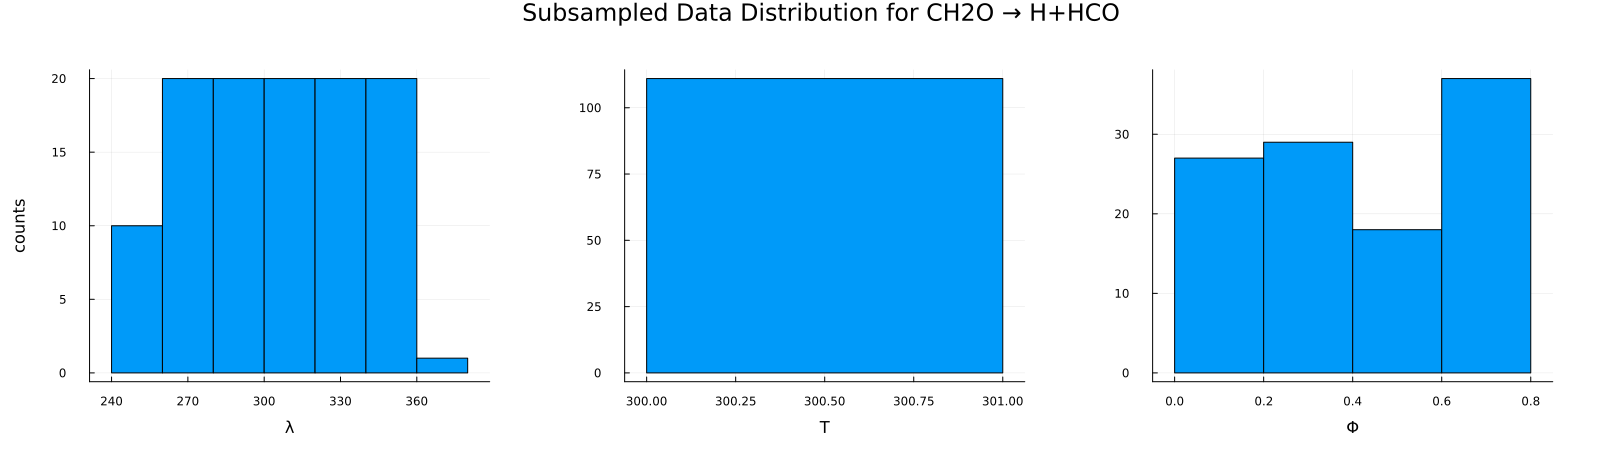

In [85]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df_sampled.Φ, xlabel="Φ", label="", margin=10Plots.mm)

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(reaction)")

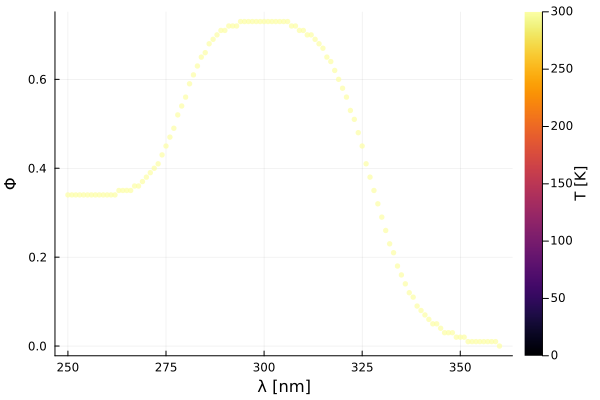

In [86]:
p2 = scatter(
    df_sampled.λ,
    df_sampled.Φ,
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


# GPR Fit

In [87]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

105


In [88]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = df_sampled.Φ[idxs_train]
ytest = df_sampled.Φ[idxs_test]

6-element Vector{Float64}:
 0.45
 0.71
 0.05
 0.03
 0.68
 0.43

In [89]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = 0.1 # std(Xtrain.T)/κ  # since we only have one temp

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

# replacing with previously found best-fit values
θ_init = (σf²=positive(0.09713245355268793), ℓ_λ=positive(13.318702718979678), ℓ_T=positive(0.10007491659587323))
σₙ² = 7.433340543708329e-6


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [90]:
μ_init = 0.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = 0.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.331679884794362, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.589169265780382, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.3018363564201247, exp, 1.4901161193847656e-8)), 
  σ² = 7.433340543708329e-6, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [91]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -4.049770e+02     4.275466e+00
 * time: 0.00016880035400390625
     1    -4.049938e+02     4.861724e-01
 * time: 0.00533294677734375
     2    -4.049943e+02     5.496620e-01
 * time: 0.011322975158691406
     3    -4.049969e+02     8.185296e-02
 * time: 0.019107818603515625
     4    -4.049974e+02     2.150523e-01
 * time: 0.02690887451171875
     5    -4.049979e+02     1.008345e-03
 * time: 0.03182196617126465
     6    -4.049979e+02     9.610100e-04
 * time: 0.041977882385253906
     7    -4.049977e+02     2.534312e-03
 * time: 0.0481870174407959
     8    -4.049980e+02     2.093966e-03
 * time: 0.05299782752990723
     9    -4.049978e+02     6.061212e-04
 * time: 0.11345100402832031
    10    -4.049976e+02     2.141294e-03
 * time: 0.12408280372619629
    11    -4.049973e+02     6.283400e-04
 * time: 0.1323258876800537
    12    -4.049973e+02     8.728798e-04
 * time: 0.1362748146057129
    13    -4.049973e+02     1.049841e-03
 * ti

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @993 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @032 ⏎ AbstractVector{Continuous}


# Model Evaluation for pathway 1

In [92]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [-2.313755079301516, 2.5971290149039596, -2.3019388986292255, -11.824590106652781],
 minimum = -404.997464539059,
 iterations = 180,
 converged = true,)

In [93]:
fp =fitted_params(mach)

(θ_best = [:σf² => 0.09888923153711353, :ℓ_λ => 13.425139293407378, :ℓ_T => 0.10006465522049895],
 σ² = 7.337171616072328e-6,)

In [94]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

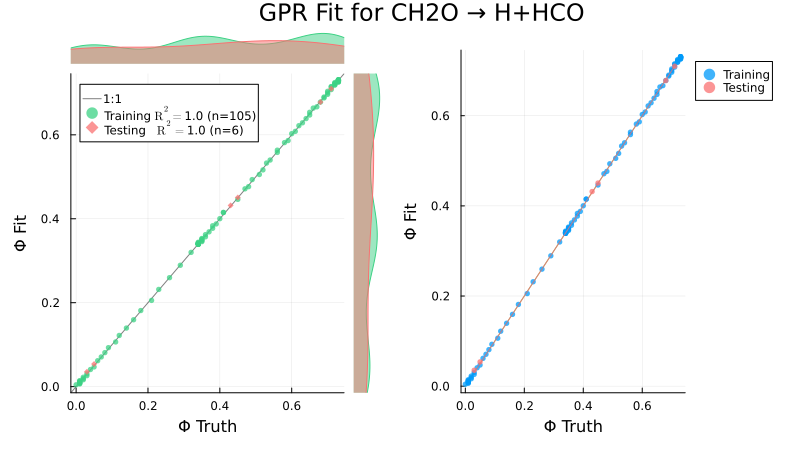

In [95]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

p2 = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

plot(p, p2, layout=(1,2), size=(800, 450), plot_title="GPR Fit for $(reaction)", margins=5Plots.mm)

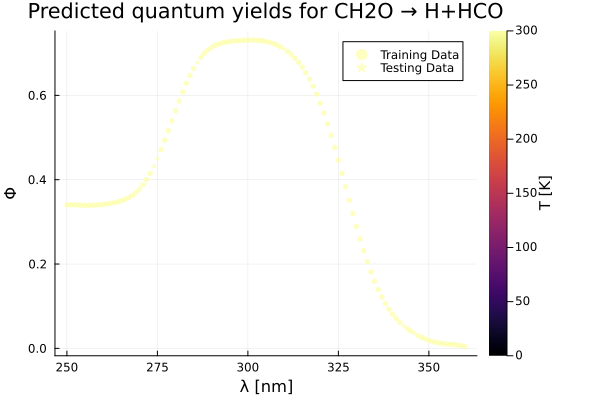

In [96]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted quantum yields for $(reaction)",
    label="Testing Data",
)


250.0
360.0


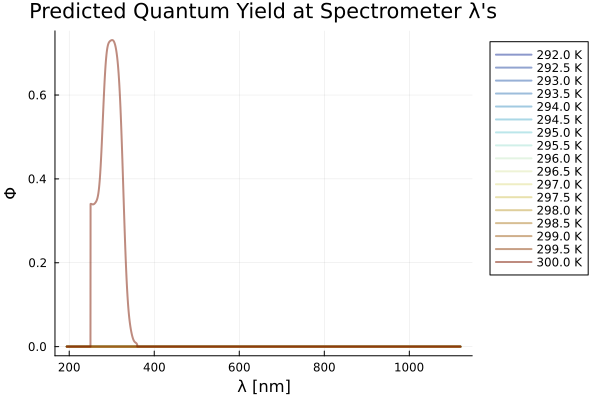

In [97]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1

for T ∈ Ts
    Φ = predict_Φ(T, hr4000_df, mach, (λ_min, λ_max))
   
    plot!(
        hr4000_df.λ, Φ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end


xlabel!("λ [nm]")
ylabel!("Φ")
title!("Predicted Quantum Yield at Spectrometer λ's")

# Output for Photolysis Rate Determination

In [98]:
df_photolysis_Φ = CSV.File("../photolysis_Φ.csv") |> DataFrame

3648×10 DataFrame
  Row │ Φ_1      Φ_2      Φ_3      Φ_4      Φ_6      Φ_5      Φ_7      Φ_8     ⋯
      │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0 ⋯
    2 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    3 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    4 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    5 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0 ⋯
    6 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    7 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    8 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    9 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0 ⋯
   10 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
   11 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
  ⋮   │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮    ⋱
 3639 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3640 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0 ⋯
 3641 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3642 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3643 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3644 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0 ⋯
 3645 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3646 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3647 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3648 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0 ⋯
                                                 2 columns and 3627 rows omitted

In [99]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

#println(λ_min, "\t", minimum(df_photolysis_σ.λ))
#println(λ_max, "\t", maximum(df_photolysis_σ.λ))

360.0

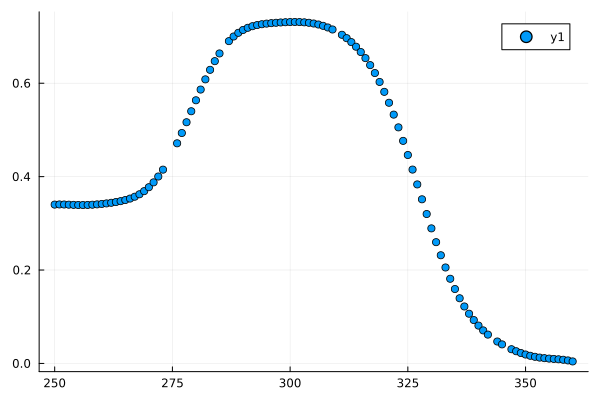

In [100]:
df_pred = sort!(Xtrain[Xtrain.T .== 300.0, :], :λ)
Φ_pred = predict_mean(mach, df_pred);

scatter(df_pred.λ, Φ_pred)

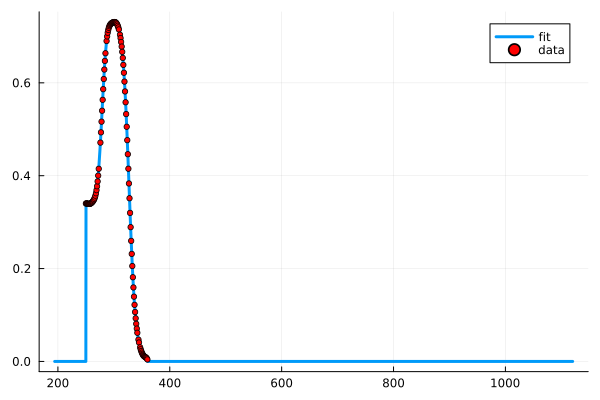

In [101]:
using DataInterpolations

cs = LinearInterpolation(Φ_pred, df_pred.λ)
Φ_out = cs(hr4000_df.λ)

# set anything outside of λ range to 0 as well
Φ_out[Φ_out .< 0.0] .= 0.0
Φ_out[ hr4000_df.λ .≥ λ_max] .= 0.0
Φ_out[hr4000_df.λ .≤ λ_min] .= 0.0


plot(hr4000_df.λ, Φ_out, lw=3, label="fit")
scatter!(df_pred.λ, Φ_pred, color=:red, ms=3, label="data")

In [102]:
df_photolysis_Φ.Φ_11 = Φ_out

describe(df_photolysis_Φ)

10×7 DataFrame
 Row │ variable  mean        min      median   max       nmissing  eltype   
     │ Symbol    Float64     Float64  Float64  Float64   Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Φ_1       0.114981        0.0      0.0  1.0              0  Float64
   2 │ Φ_2       0.885019        0.0      1.0  1.0              0  Float64
   3 │ Φ_3       0.963542        0.0      1.0  1.0              0  Float64
   4 │ Φ_4       0.214167        0.0      0.0  1.0              0  Float64
   5 │ Φ_6       0.426121        0.0      0.0  1.0              0  Float64
   6 │ Φ_5       0.00986771      0.0      0.0  0.344696         0  Float64
   7 │ Φ_7       0.211623        0.0      0.0  1.0              0  Float64
   8 │ Φ_8       0.945175        0.0      1.0  1.0              0  Float64
   9 │ Φ_11      0.0470227       0.0      0.0  0.73106          0  Float64
  10 │ Φ_12      0.0452994       0.0      0.0  0.709784         0  Float64

In [103]:
CSV.write("../photolysis_Φ.csv", df_photolysis_Φ)

"../photolysis_Φ.csv"

# Pathway 2

In [104]:
rxn = rxn2
λs, Φs, T1s, T2s, species, source_idx, T_units, category, reaction, λ_units, Φ_units  = get_raw_data(h5_path, rxn)

([290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 290.0, 300.0  …  357.0, 358.0, 359.0, 360.0, 313.0, 334.0, 366.0, 313.0, 334.0, 366.0], [0.19, 0.34, 0.48, 0.6, 0.71, 0.82, 0.91, 0.99, 0.19, 0.34  …  0.17, 0.15, 0.14, 0.12, 0.2, 0.25, 0.45, 0.2, 0.25, 0.45], [298.0, 294.0, 353.0, 220.0, 298.0, 298.0, 300.0, 353.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, 392.0], [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  2, 2, 2, 2, 1, 1, 1, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  7, 7, 7, 7, 8, 8, 8, 8, 8, 8], "K", "Organics (carbonyls)", "CH2O → H2+CO", "nm", "")

In [105]:
unique(species)

2-element Vector{Int64}:
 1
 2

In [106]:
reaction

"CH2O → H2+CO"

In [107]:
species_to_use = 1 
df = data_to_df(λs, Φs, T1s, T2s, source_idx, species, species_to_use)

145×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   290.0    0.19     298.0          1
   2 │   300.0    0.34     298.0          1
   3 │   310.0    0.48     298.0          1
   4 │   320.0    0.6      298.0          1
   5 │   330.0    0.71     298.0          1
   6 │   340.0    0.82     298.0          1
   7 │   350.0    0.91     298.0          1
   8 │   360.0    0.99     298.0          1
   9 │   299.1    1.0      294.0          2
  10 │   326.2    0.9      294.0          2
  11 │   329.8    0.96     294.0          2
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 136 │   351.0    0.33     300.0          7
 137 │   352.0    0.3      300.0          7
 138 │   353.0    0.27     300.0          7
 139 │   354.0    0.24     300.0          7
 140 │   355.0    0.22     300.0          7
 141 │   356.0    0.2      300.0          7
 142 │   357.0    0.17     300.0          7
 143 │   358.0    0.15     300.0          7
 144 │   359.0    0.14     300.0          7
 145 │   360.0    0.12     300.0          7
                            124 rows omitted

In [108]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [109]:
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

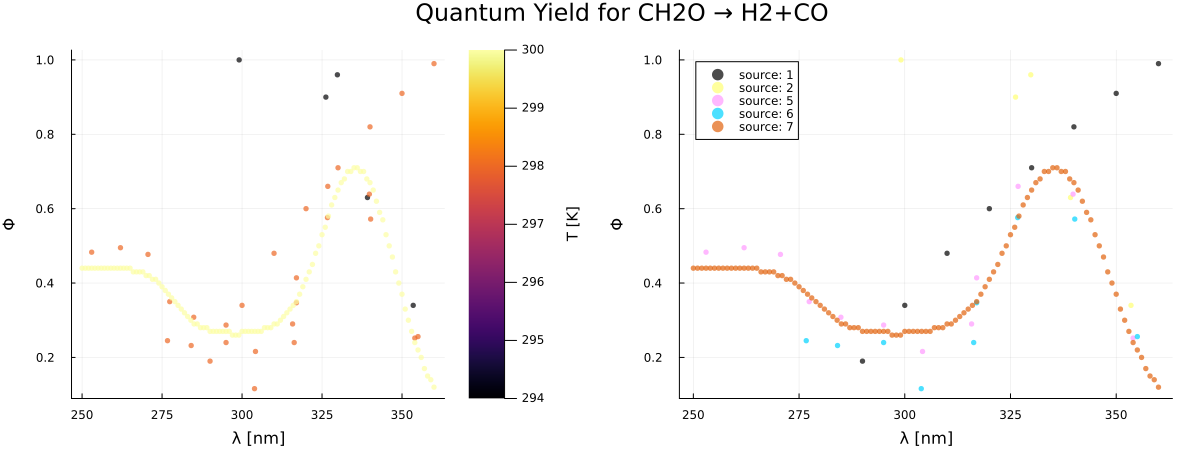

In [110]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    df.Φ[1:nskip:end],
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        df_g.Φ[1:nskip:end],
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="Φ",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Quantum Yield for $(reaction)",)

In [111]:
df = df[df.source_id .== 7, :]

111×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   250.0     0.44    300.0          7
   2 │   251.0     0.44    300.0          7
   3 │   252.0     0.44    300.0          7
   4 │   253.0     0.44    300.0          7
   5 │   254.0     0.44    300.0          7
   6 │   255.0     0.44    300.0          7
   7 │   256.0     0.44    300.0          7
   8 │   257.0     0.44    300.0          7
   9 │   258.0     0.44    300.0          7
  10 │   259.0     0.44    300.0          7
  11 │   260.0     0.44    300.0          7
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 102 │   351.0     0.33    300.0          7
 103 │   352.0     0.3     300.0          7
 104 │   353.0     0.27    300.0          7
 105 │   354.0     0.24    300.0          7
 106 │   355.0     0.22    300.0          7
 107 │   356.0     0.2     300.0          7
 108 │   357.0     0.17    300.0          7
 109 │   358.0     0.15    300.0          7
 110 │   359.0     0.14    300.0          7
 111 │   360.0     0.12    300.0          7
                             90 rows omitted

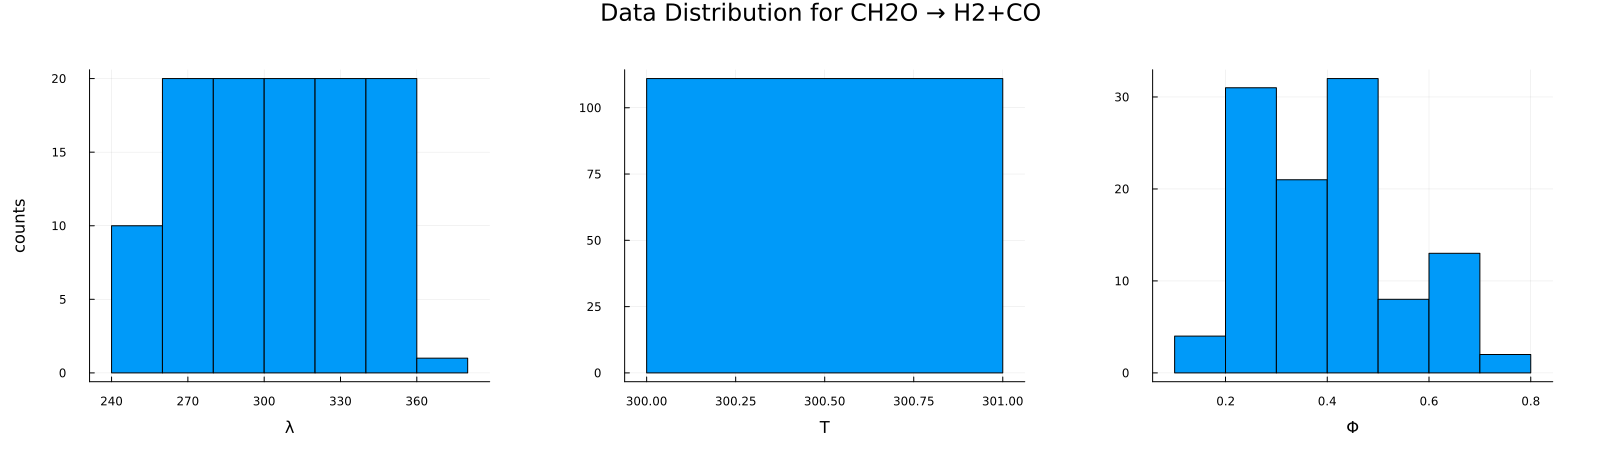

In [112]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df.Φ, xlabel="Φ", label="", margin=10Plots.mm)
phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(reaction)")

# Data Preprocessing

In [113]:
gdfs = groupby(df, :T)

res_dfs = [] 

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:Φ, :T] .=> mean, renamecols=false))
end

df_unique = vcat(res_dfs...)

111×3 DataFrame
 Row │ λ        Φ        T       
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │   250.0     0.44    300.0
   2 │   251.0     0.44    300.0
   3 │   252.0     0.44    300.0
   4 │   253.0     0.44    300.0
   5 │   254.0     0.44    300.0
   6 │   255.0     0.44    300.0
   7 │   256.0     0.44    300.0
   8 │   257.0     0.44    300.0
   9 │   258.0     0.44    300.0
  10 │   259.0     0.44    300.0
  11 │   260.0     0.44    300.0
  ⋮  │    ⋮        ⋮        ⋮
 102 │   351.0     0.33    300.0
 103 │   352.0     0.3     300.0
 104 │   353.0     0.27    300.0
 105 │   354.0     0.24    300.0
 106 │   355.0     0.22    300.0
 107 │   356.0     0.2     300.0
 108 │   357.0     0.17    300.0
 109 │   358.0     0.15    300.0
 110 │   359.0     0.14    300.0
 111 │   360.0     0.12    300.0
                  90 rows omitted

In [114]:
# λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# Φ_idxs = representative_rand_sample(df_unique.Φ, 500, 2000) 
# idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

df_sampled = df_unique
max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

250.0

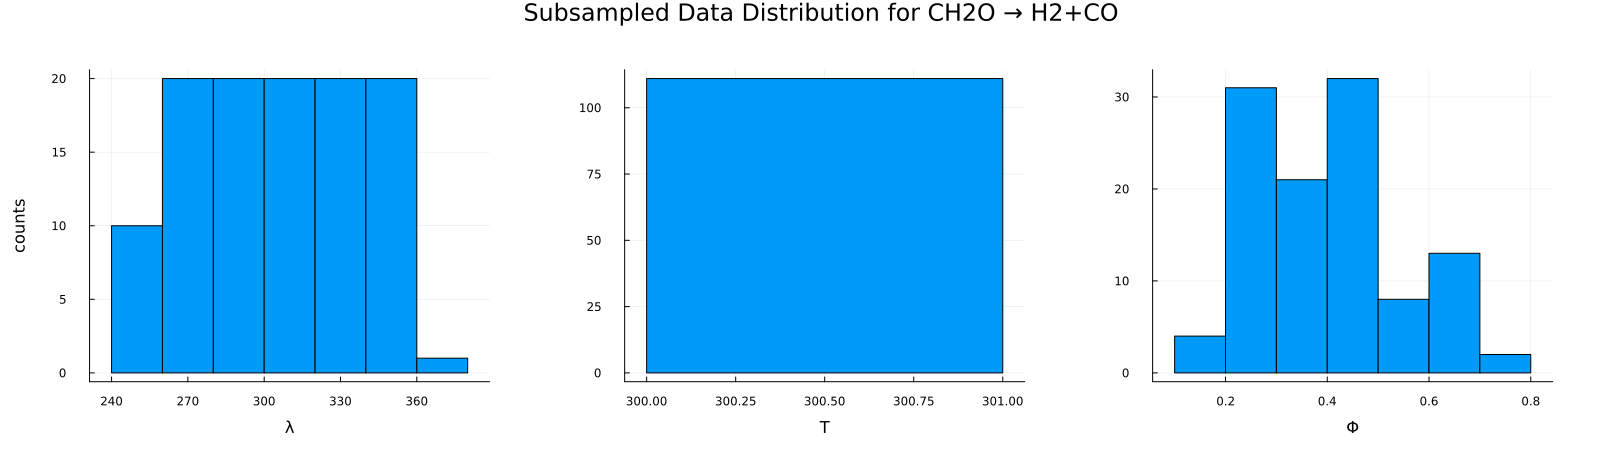

In [115]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df_sampled.Φ, xlabel="Φ", label="", margin=10Plots.mm)

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(reaction)")

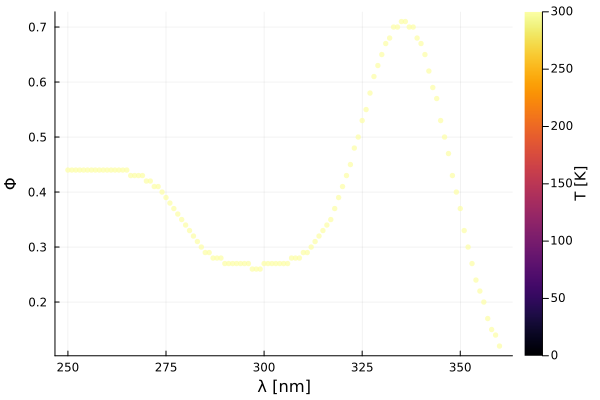

In [116]:
p2 = scatter(
    df_sampled.λ,
    df_sampled.Φ,
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


# GPR Fit

In [117]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

105


In [118]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = df_sampled.Φ[idxs_train]
ytest = df_sampled.Φ[idxs_test]

6-element Vector{Float64}:
 0.61
 0.27
 0.44
 0.35
 0.37
 0.68

In [119]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = 0.1 # std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

# replacing with previously found best-fit values
θ_init = (σf²=positive(0.086301908892231), ℓ_λ=positive(15.442509622054448), ℓ_T=positive(0.09997552742428895))
σₙ² = 9.822148753580453e-6

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [120]:
μ_init = 0.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = 0.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.4499037345394896, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.737124070711945, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.3028299977494897, exp, 1.4901161193847656e-8)), 
  σ² = 9.822148753580453e-6, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [121]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -4.020006e+02     3.749364e+00
 * time: 0.0002129077911376953
     1    -4.020450e+02     2.692711e+00
 * time: 0.007951974868774414
     2    -4.021255e+02     1.997633e+00
 * time: 0.013308048248291016
     3    -4.021325e+02     1.829799e-02
 * time: 0.019429922103881836
     4    -4.021327e+02     2.044227e-02
 * time: 0.02751898765563965
     5    -4.021329e+02     7.616643e-03
 * time: 0.03584599494934082
     6    -4.021326e+02     2.847302e-03
 * time: 0.05092191696166992
     7    -4.021332e+02     2.571913e-03
 * time: 0.057615041732788086
     8    -4.021329e+02     1.755737e-03
 * time: 0.07184886932373047
     9    -4.021328e+02     1.065485e-03
 * time: 0.07490301132202148
    10    -4.021330e+02     1.119820e-03
 * time: 0.08074808120727539
    11    -4.021329e+02     5.617701e-04
 * time: 0.11446404457092285
    12    -4.021330e+02     3.332278e-03
 * time: 0.11777591705322266
    13    -4.021326e+02     1.362629e-03
 *

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @473 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @339 ⏎ AbstractVector{Continuous}


# Model Evaluation for pathway 2 

In [122]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [-2.4529157161501387, 2.7239645152210463, -2.303798883874077, -11.606181967059603],
 minimum = -402.13261805566384,
 iterations = 609,
 converged = true,)

In [123]:
fp =fitted_params(mach)

(θ_best = [:σf² => 0.08604236024865593, :ℓ_λ => 15.240624333717875, :ℓ_T => 0.09987870944777773],
 σ² = 9.124499233515353e-6,)

In [124]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

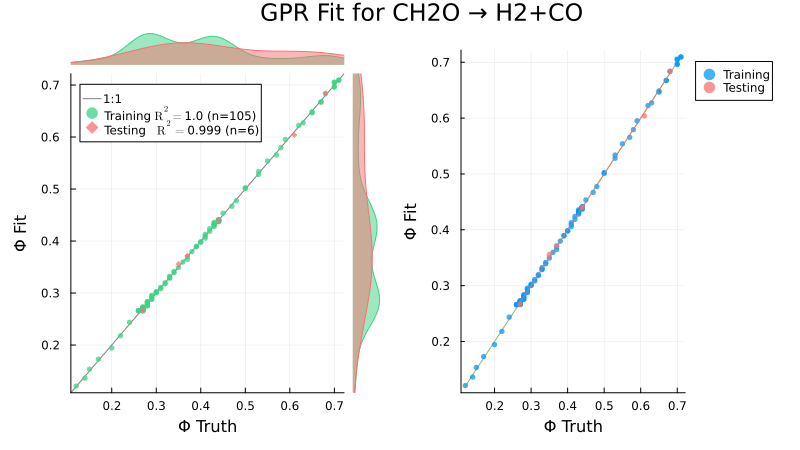

In [125]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

p2 = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

plot(p, p2, layout=(1,2), size=(800, 450), plot_title="GPR Fit for $(reaction)", margins=5Plots.mm)

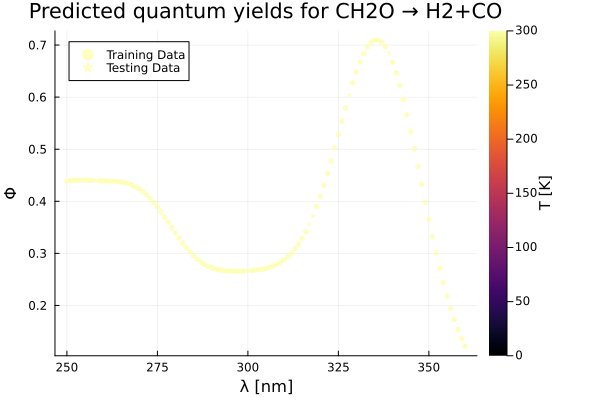

In [126]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted quantum yields for $(reaction)",
    label="Testing Data",
)


250.0
360.0


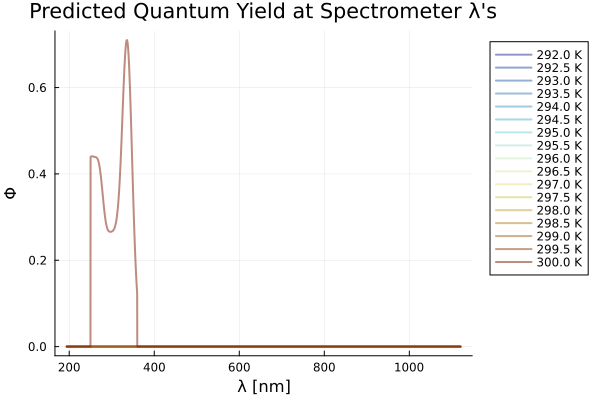

In [127]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    Φ = predict_Φ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, Φ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("Φ")
title!("Predicted Quantum Yield at Spectrometer λ's")

# Output for Photolysis Rate Determination

In [128]:
df_photolysis_Φ = CSV.File("../photolysis_Φ.csv") |> DataFrame

3648×10 DataFrame
  Row │ Φ_1      Φ_2      Φ_3      Φ_4      Φ_6      Φ_5      Φ_7      Φ_8     ⋯
      │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0 ⋯
    2 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    3 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    4 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    5 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0 ⋯
    6 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    7 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    8 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
    9 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0 ⋯
   10 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
   11 │     1.0      0.0      0.0      1.0      1.0      0.0      1.0      0.0
  ⋮   │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮    ⋱
 3639 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3640 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0 ⋯
 3641 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3642 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3643 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3644 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0 ⋯
 3645 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3646 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3647 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0
 3648 │     0.0      1.0      1.0      0.0      0.0      0.0      0.0      1.0 ⋯
                                                 2 columns and 3627 rows omitted

In [129]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

#println(λ_min, "\t", minimum(df_photolysis_σ.λ))
#println(λ_max, "\t", maximum(df_photolysis_σ.λ))

360.0

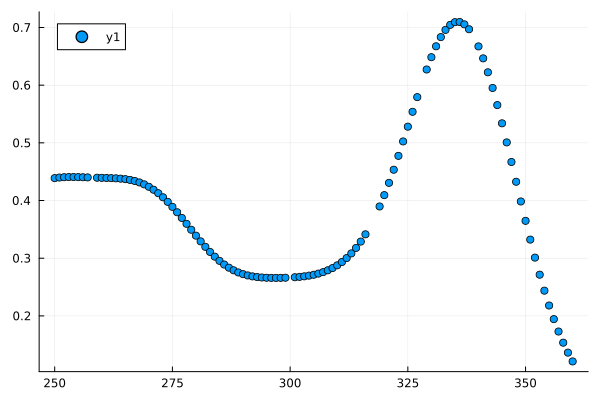

In [130]:
df_pred = sort!(Xtrain[Xtrain.T .== 300.0, :], :λ)
Φ_pred = predict_mean(mach, df_pred);

scatter(df_pred.λ, Φ_pred)

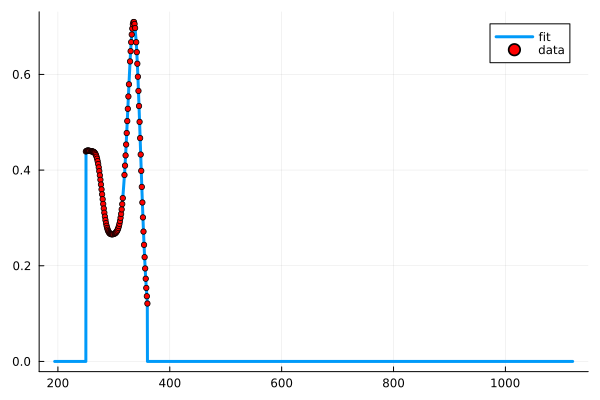

In [131]:
using DataInterpolations

cs = LinearInterpolation(Φ_pred, df_pred.λ)
Φ_out = cs(hr4000_df.λ)

# set anything outside of λ range to 0 as well
Φ_out[Φ_out .< 0.0] .= 0.0
Φ_out[ hr4000_df.λ .≥ λ_max] .= 0.0
Φ_out[hr4000_df.λ .≤ λ_min] .= 0.0


plot(hr4000_df.λ, Φ_out, lw=3, label="fit")
scatter!(df_pred.λ, Φ_pred, color=:red, ms=3, label="data")

In [132]:
df_photolysis_Φ.Φ_12 = Φ_out

describe(df_photolysis_Φ)

10×7 DataFrame
 Row │ variable  mean        min      median   max       nmissing  eltype   
     │ Symbol    Float64     Float64  Float64  Float64   Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Φ_1       0.114981        0.0      0.0  1.0              0  Float64
   2 │ Φ_2       0.885019        0.0      1.0  1.0              0  Float64
   3 │ Φ_3       0.963542        0.0      1.0  1.0              0  Float64
   4 │ Φ_4       0.214167        0.0      0.0  1.0              0  Float64
   5 │ Φ_6       0.426121        0.0      0.0  1.0              0  Float64
   6 │ Φ_5       0.00986771      0.0      0.0  0.344696         0  Float64
   7 │ Φ_7       0.211623        0.0      0.0  1.0              0  Float64
   8 │ Φ_8       0.945175        0.0      1.0  1.0              0  Float64
   9 │ Φ_11      0.0470227       0.0      0.0  0.73106          0  Float64
  10 │ Φ_12      0.0453115       0.0      0.0  0.709551         0  Float64

In [133]:
CSV.write("../photolysis_Φ.csv", df_photolysis_Φ)

"../photolysis_Φ.csv"